# RNN Explanation via Local Surrogate Model using the Declarative Feature Space based on a  Process Specification

We demonstrate the utility of the domain driven Declare feature space by explaining a black-box model trained for automatic conformance checking. For this application example, we use the Road Traffic Fine Management (RTFM) dataset, which records the lifecycle of traffic fine handling ranging from issuing a fine to its payment or credit collection.

To establish ground truth for conformance, we adopt the standard business process model specification provided by García-Bañuelos, et al., which is visualized in the figure below in Business Process Modelling Notation (BPMN). We use the PM4Py library to label sequences as conformant or non-conformant by converting the BPMN model into a Petri net and applying alignment-based conformance checking. From this BPMN model, we derived the Declare constraints using the translation approach formulated by Khorunzhaia, which serve as the interpretable feature space for our subsequent explanations.

Dataset: Road Traffic Fine Management (RTFMP) https://doi.org/10.4121/uuid:270fd440-1057-4fb9-89a9-b699b47990f5

BPMN Model for RTFMP from García-Bañuelos, L., Van Beest, N.R., Dumas, M., La Rosa, M., Mertens, W.: Complete and interpretable conformance checking of business processes. IEEE Transactions on Software Engineering 44(3), 262–290 (2017)

![alt text](../img/rtfmp_bpmn_model.png)

## The Declarative Model and Feature Space


Model Translated to Declare using accodring to the methodology described by Khorunzhaia, M.: From BPMN to DECLARE: Developing a Systematic Approach for Process Modeling Translation. Master’s thesis, Utrecht University (2025)

> Khorunzhaia's translation methodology often results in Declare constraints where one event is related to a set of other events. To simplify processing, we represent these set-based constraints in our `model_str` using curly braces `{}`. The subsequent Python code parses this string and expands each set-based constraint into multiple individual constraints. For example, a constraint like `Response(A, {B, C})` is automatically split into two separate constraints: `Response(A, B)` and `Response(A, C)`. This expansion creates a flat list of simple constraints that form the basis of our declarative feature space.

In [1]:
# Random Seeds for reproducibility
import random
import numpy as np
random_seed=42

np.random.seed(random_seed)
random.seed(random_seed)

In [2]:
from src.declare.constraints import Existence, Precedence, RespondedExistence, Response, AlternateSuccession, AlternatePrecedence, AlternateResponse, NotCoexistence, Init, End
from src.declare.declare_feature_space import DeclarativeFeatureSpace

model_str = """
Init(Create Fine)
End({Send for Credit Collection, Payment})


Response(Create Fine, {Send Fine, Payment})
Precedence(Create Fine, {Send Fine, Payment})

Response(Send Fine, {Insert Fine Notification, Payment})
AlternatePrecedence(Send Fine, {Insert Fine Notification})

AlternateResponse(Insert Fine Notification, {Add penalty, Payment, Appeal to Judge, Insert Date Appeal to Prefecture})
AlternatePrecedence(Insert Fine Notification, {Add penalty, Appeal to Judge, Insert Date Appeal to Prefecture})

AlternateResponse(Add penalty, {Send for Credit Collection, Payment, Appeal to Judge, Insert Date Appeal to Prefecture})
AlternatePrecedence(Add penalty, {Send for Credit Collection,  Appeal to Judge, Insert Date Appeal to Prefecture})

Response(Appeal to Judge, {Appeal to Judge, Insert Date Appeal to Prefecture, Payment})
Precedence(Appeal to Judge, {Appeal to Judge, Insert Date Appeal to Prefecture})

Response(Notify Result Appeal to Offender, {Appeal to Judge, Insert Date Appeal to Prefecture, Payment})
Precedence(Notify Result Appeal to Offender, {Appeal to Judge, Insert Date Appeal to Prefecture})

AlternateResponse(Insert Date Appeal to Prefecture, Send Appeal to Prefecture)
AlternatePrecedence(Insert Date Appeal to Prefecture, Send Appeal to Prefecture)

AlternateResponse(Send Appeal to Prefecture, Receive Result Appeal from Prefecture)
AlternatePrecedence(Send Appeal to Prefecture, Receive Result Appeal from Prefecture)

AlternateResponse(Receive Result Appeal from Prefecture, Notify Result Appeal to Offender)
AlternatePrecedence(Receive Result Appeal from Prefecture, Notify Result Appeal to Offender)

Precedence({Create Fine, Send Fine, Insert Fine Notification, Add penalty, Appeal to Judge, Notify Result Appeal to Offender}, Payment)

notcoexistence(Payment, Send for Credit Collection)
"""

const = model_str.split("\n")
const = [x for x in const if x != ""]

done = False
while not done:
    done = True
    new_const = []
    for x in const:
        if "{" in x:
            opening_index = x.index("{")
            closing_index = x.index("}")
            ored_events = x[opening_index + 1:closing_index].split(", ")
            done = False
            for event in ored_events:
                new_const.append(x[:opening_index] + event + x[closing_index + 1:])
        else:
            new_const.append(x)
    const = new_const

const = [x.split("(") for x in const]
const = [(x[0], x[1].replace(")", "").split(", ")) for x in const]



const_map = {
    "Existence": Existence,
    "Precedence": Precedence,
    "RespondedExistence": RespondedExistence,
    "Response": Response,
    "AlternateSuccession": AlternateSuccession,
    "AlternatePrecedence": AlternatePrecedence,
    "AlternateResponse": AlternateResponse,
    "notcoexistence": NotCoexistence,
    "Init": Init,
    "End": End
}

for x in const:
    assert x[0] in const_map.keys()

unary_constraints = ["Init", "End", "Existence"]

unary_constraintset = [const_map[x[0]](x[1][0]) for x in const if x[0] in unary_constraints]
binary_constraintset = [const_map[x[0]](x[1][0], x[1][1]) for x in const if x[0] not in unary_constraints]

constraints = unary_constraintset + binary_constraintset
ds = DeclarativeFeatureSpace(constraints=constraints)
ds.get_features()

['Init(Create Fine)',
 'End(Send for Credit Collection)',
 'End(Payment)',
 'Response(Create Fine, Send Fine)',
 'Response(Create Fine, Payment)',
 'Precedence(Create Fine, Send Fine)',
 'Precedence(Create Fine, Payment)',
 'Response(Send Fine, Insert Fine Notification)',
 'Response(Send Fine, Payment)',
 'AlternatePrecedence(Send Fine, Insert Fine Notification)',
 'AlternateResponse(Insert Fine Notification, Add penalty)',
 'AlternateResponse(Insert Fine Notification, Payment)',
 'AlternateResponse(Insert Fine Notification, Appeal to Judge)',
 'AlternateResponse(Insert Fine Notification, Insert Date Appeal to Prefecture)',
 'AlternatePrecedence(Insert Fine Notification, Add penalty)',
 'AlternatePrecedence(Insert Fine Notification, Appeal to Judge)',
 'AlternatePrecedence(Insert Fine Notification, Insert Date Appeal to Prefecture)',
 'AlternateResponse(Add penalty, Send for Credit Collection)',
 'AlternateResponse(Add penalty, Payment)',
 'AlternateResponse(Add penalty, Appeal to Judg

## Loading the Event log

this requires the enriched eventlog as created by conformance checking, see [here](./miscellaneous/conformance_checking.ipynb)

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import random

data = pd.read_csv("eventlogs/rtfmp/final_enriched_event_log.csv")
data["timestamp"] = pd.to_datetime(data["time:timestamp"])
data

,concept:name,amount,org:resource,dismissal,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,Cluster,conformance_result,declare_conformance_result,timestamp
0,Create Fine,35.0,561.0,NIL,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,0,Missing activity: Payment,"End({Send for Credit Collection, Payment}) | R...",2006-07-24 00:00:00+00:00
1,Send Fine,NaN,NaN,NaN,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.00,NaN,NaN,NaN,NaN,0,Missing activity: Payment,"End({Send for Credit Collection, Payment}) | R...",2006-12-05 00:00:00+00:00
2,Create Fine,35.0,561.0,NIL,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,2006-08-02 00:00:00+00:00
3,Send Fine,NaN,NaN,NaN,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.00,NaN,NaN,NaN,NaN,4,NaN,NaN,2006-12-12 00:00:00+00:00
4,Insert Fine Notification,NaN,NaN,NaN,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,4,NaN,NaN,2007-01-15 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,Create Fine,131.0,25.0,NIL,A,0.0,complete,2002-09-07 00:00:00+00:00,142.0,0.0,V9999,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,2002-09-07 00:00:00+00:00
561466,Send Fine,NaN,NaN,NaN,NaN,NaN,complete,2002-10-25 00:00:00+00:00,NaN,NaN,V9999,15.16,NaN,NaN,NaN,NaN,4,NaN,NaN,2002-10-25 00:00:00+00:00
561467,Insert Fine Notification,NaN,NaN,NaN,NaN,NaN,complete,2002-11-04 00:00:00+00:00,NaN,NaN,V9999,NaN,P,N,NaN,NaN,4,NaN,NaN,2002-11-04 00:00:00+00:00
561468,Add penalty,262.0,NaN,NaN,NaN,NaN,complete,2003-01-03 00:00:00+00:00,NaN,NaN,V9999,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,2003-01-03 00:00:00+00:00


## Load a trained RNN

The RNN model, `SequenceClassifier`, is designed for binary sequence classification. It processes event sequences to predict a binary outcome (e.g., conforming vs. non-conforming). The model training is shown [here](./miscellaneous/rnn_sequence_classifier_train.ipynb)

The model architecture consists of three main layers:
1.  **Embedding Layer (`nn.Embedding`)**: This layer transforms each event ID from the input sequence into a dense vector of a specified dimension (`emb_dim`). This allows the model to learn a meaningful representation for each event.
2.  **RNN Layer (`nn.RNN`)**: This layer processes the sequence of embedding vectors. It maintains a hidden state that captures information from the preceding events in the sequence. The final hidden state of the RNN, which summarizes the entire sequence, is used for classification. The model uses `pack_padded_sequence` to efficiently handle sequences of varying lengths within a batch.
3.  **Fully Connected Layer (`nn.Linear`)**: This final layer takes the RNN's final hidden state and maps it to a single output logit, which represents the model's prediction before the activation function.

In [4]:
# Import model architecture from training notebook
class SequenceClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=16, hidden_dim=32):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, lengths):
        x = self.emb(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h = self.rnn(packed)
        out = self.fc(h[-1])
        return out

### Load Pre-Trained Model Components


In [5]:
dt = []

for case, g in data.groupby("case:concept:name"):
    # Label (angenommen: pro Case konstant)
    label = 1 if g["conformance_result"].isna().iloc[0] else 0

    # Geordnete Sequenz
    sequence = (
        g.sort_values("timestamp")["concept:name"]
        .tolist()
    )

    dt.append((sequence, label))





dt_unique = list({(tuple(seq), label) for seq, label in dt})
dt_unique = [(list(seq), label) for seq, label in dt_unique] 


dt_conf = [x for x in dt_unique if x[1] == 1]   # conformant
dt_nonconf = [x for x in dt_unique if x[1] == 0]  # non-conformant


n_conf_train = int(0.8 * len(dt_conf))
n_nonconf_train = int(0.8 * len(dt_nonconf))

dt_conf_train = random.sample(dt_conf, n_conf_train)
dt_nonconf_train = random.sample(dt_nonconf, n_nonconf_train)


dt_train = dt_conf_train + dt_nonconf_train



In [6]:
unique_dt = list({
    (tuple(seq), label)
    for seq, label in dt_train
})

In [7]:
# Vokabular bauen
all_events = sorted({e for seq,_ in unique_dt for e in seq})
event2id = {e:i+1 for i,e in enumerate(all_events)}  # IDs ab 1
event2id["<pad>"] = 0
id2event = {i:e for e,i in event2id.items()}

vocab_size = len(event2id)

In [8]:
# Load the trained model weights
import os

model = SequenceClassifier(vocab_size)
model.load_state_dict(torch.load(os.path.join( "eventlogs", "rtfmp", "sequence_classifier.pth"), map_location=torch.device('cpu')))
model.eval()

SequenceClassifier(
  (emb): Embedding(12, 16)
  (rnn): RNN(16, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

### Helper Functions for Classification

To make predictions with the trained RNN model, we define two helper functions: `classify` and `classify_many`.

-   **`classify(seq)`**: This function takes a single event sequence as input. It first converts the sequence of event names into a tensor of corresponding IDs using the `event2id` mapping. It then feeds this tensor, along with its length, into the loaded `model`. The function returns the raw prediction probability (after a sigmoid activation) and the final binary classification (1 for conforming, 0 for non-conforming), which is determined by a threshold of 0.5.

-   **`classify_many(seq_list)`**: This utility function simplifies the process of classifying multiple sequences at once. It takes a list of event sequences, iterates through them, and applies the `classify` function to each, returning a list of their binary predictions.

In [9]:

def classify(seq):
    ids = torch.tensor([event2id[e] for e in seq]).unsqueeze(0)
    lengths = torch.tensor([len(seq)])

    with torch.no_grad():
        logit = model(ids, lengths)
        prob = torch.sigmoid(logit).item()

    return prob, int(prob > 0.5)

def classify_many(seq_list):
    seq_list = list(seq_list)
    return [classify(x)[1] for x in seq_list]

## Predicting conformance of sequences using SequenceClassifier

In [10]:
trace_conf = dt_conf[1][0]
trace_nonconf = dt_nonconf[0][0]

# 1 = conforming, 0 = non-conforming

print("=" * 60)
print("TRACE CLASSIFICATION RESULTS")
print("=" * 60)

print(f"\n✓ Conforming Trace:\n  {'→'.join(trace_conf)}")
res_conf = classify(trace_conf)
print(f"  Probability: {res_conf[0]:.4f} | Prediction: {'Conforming' if res_conf[1] == 1 else 'Non-Conforming'}")

print(f"\n✗ Non-Conforming Trace:\n  {'→'.join(trace_nonconf)}")
res_nonconf = classify(trace_nonconf)
print(f"  Probability: {res_nonconf[0]:.4f} | Prediction: {'Conforming' if res_nonconf[1] == 1 else 'Non-Conforming'}")

print("\n" + "=" * 60)

TRACE CLASSIFICATION RESULTS

✓ Conforming Trace:
  Create Fine→Send Fine→Insert Fine Notification→Add penalty→Insert Date Appeal to Prefecture→Send Appeal to Prefecture→Receive Result Appeal from Prefecture→Notify Result Appeal to Offender→Payment
  Probability: 1.0000 | Prediction: Conforming

✗ Non-Conforming Trace:
  Create Fine→Send Fine→Insert Date Appeal to Prefecture→Send Appeal to Prefecture→Insert Fine Notification→Appeal to Judge→Add penalty→Payment
  Probability: 0.0000 | Prediction: Non-Conforming



The SequenceClassifier correctly identifies the conforming and non-conforming traces. The non-conforming trace violates the process model  `Payment` and `Send for Credit Collection` as both events appear in the sequence.

Next, we demonstrate the transformation of these two event sequences into our declarative feature space, which is derived from the process model. This representation will serve as the basis for explaining the model's predictions.

In [11]:
ds.represent_matrix(ds.to_interpretable_set([np.array(trace_conf), np.array(trace_nonconf)]))

,Init(Create Fine),End(Send for Credit Collection),End(Payment),"Response(Create Fine, Send Fine)","Response(Create Fine, Payment)","Precedence(Create Fine, Send Fine)","Precedence(Create Fine, Payment)","Response(Send Fine, Insert Fine Notification)","Response(Send Fine, Payment)","AlternatePrecedence(Send Fine, Insert Fine Notification)",...,"AlternatePrecedence(Send Appeal to Prefecture, Receive Result Appeal from Prefecture)","AlternateResponse(Receive Result Appeal from Prefecture, Notify Result Appeal to Offender)","AlternatePrecedence(Receive Result Appeal from Prefecture, Notify Result Appeal to Offender)","Precedence(Create Fine, Payment)","Precedence(Send Fine, Payment)","Precedence(Insert Fine Notification, Payment)","Precedence(Add penalty, Payment)","Precedence(Appeal to Judge, Payment)","Precedence(Notify Result Appeal to Offender, Payment)","NotCoexistence(Payment, Send for Credit Collection)"
0,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,False,True,True
1,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,True


## Surrogate Model Based Explaining using the declarative Feature Space

### Training the Global Surrogate Model

To explain the predictions of the black-box RNN model, we train a global surrogate model. This surrogate is an interpretable model, in this case, a `RandomForestClassifier`, trained to approximate the behavior of the original RNN.

The training process involves these steps:
1.  **Feature Transformation**: Each event sequence from our dataset is transformed into its corresponding declarative feature vector. This vector represents the fulfillment of the Declare constraints for that sequence.
2.  **Label Generation**: The black-box RNN model predicts a label (conforming or non-conforming) for each event sequence. These predictions serve as the target labels for training the surrogate model.
3.  **Model Fitting**: The `RandomForestClassifier` is trained on the declarative feature vectors (as input) and the RNN's predictions (as output). By doing this, the surrogate model learns to map the interpretable declarative features to the predictions of the complex RNN, effectively mimicking its decision-making process.

The fidelity of this surrogate model—how well it replicates the RNN's predictions—is then measured to ensure it is a reliable proxy for explanation.

In [12]:
from sklearn.ensemble import RandomForestClassifier
# convert all traces to declerative representation
# optional use all masks for each instance to generate nmore in depth surrogate model
class DatasetEntry():

    def __init__(self, sequence, representation, label, rnn_predicted_label):
        self.sequence = sequence
        self.representation = representation
        self.label = label
        self.rnn_predicted_label = rnn_predicted_label

    def __str__(self):
        return f"{"\n ->".join(self.sequence)} \n\n predicted as { self.rnn_predicted_label},  --  ground truth: { self.label}"
    
    def correctly_predicted(self) -> bool:
        return self.label == self.rnn_predicted_label


surrogate_ds: list[DatasetEntry] =[] 

for instance in dt_unique :
    sequence = instance[0]
    label = instance[1]
    # create representation
    rep = ds.to_interpretable_instance(np.array(sequence))
    # create predicted label
    predicted = classify(sequence)
    surrogate_ds.append(
        DatasetEntry(
            sequence=sequence,
            representation=rep,
            label=label,
            rnn_predicted_label=predicted[1]  # import numpy as np
        )
    )

predicted_labels= np.array([x.rnn_predicted_label for x in surrogate_ds])
declare_features = np.array([x.representation for x in surrogate_ds])# train a surrogate model


rfc_surrogate_model = RandomForestClassifier(random_state=random_seed)
rfc_surrogate_model.fit(declare_features, predicted_labels)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
from sklearn.metrics import accuracy_score

surrogate_preds = rfc_surrogate_model.predict(declare_features)
accuracy = accuracy_score(predicted_labels, surrogate_preds)
print("Surrogate fidelity (accuracy):", accuracy)

Surrogate fidelity (accuracy): 1.0


### Using SHAP

To interpret the predictions of our surrogate model, we employ SHAP (SHapley Additive exPlanations), a state-of-the-art explainer framework. SHAP assigns an importance value to each feature for a specific prediction, revealing which declarative constraints most influenced the model's decision. This allows us to generate both global explanations, which show overall feature importance, and local explanations for individual predictions.

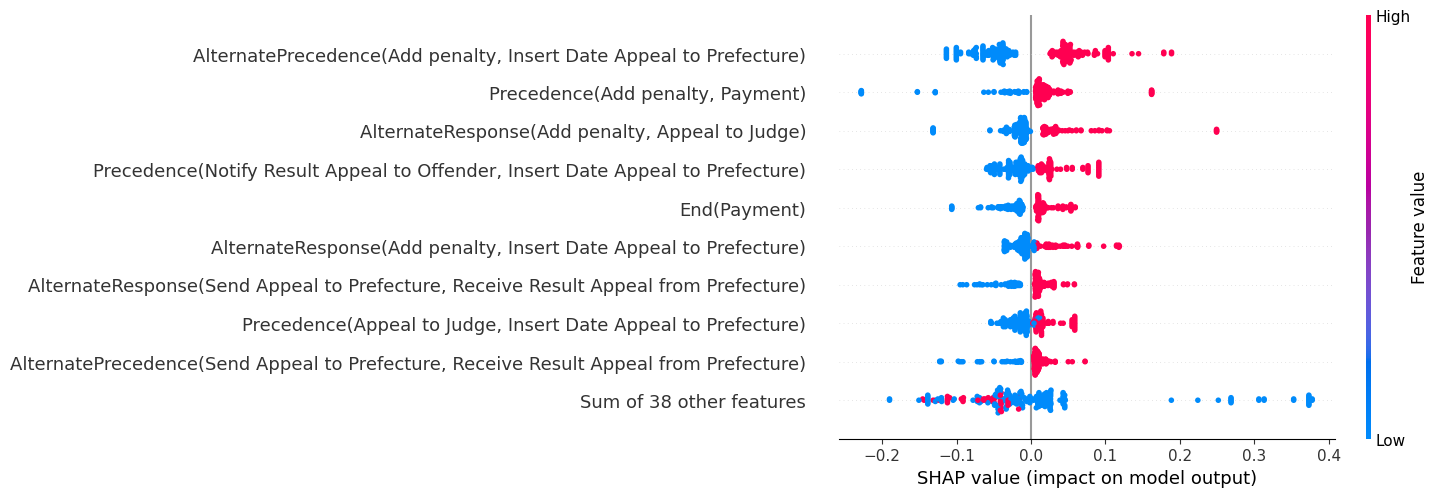

In [14]:
import matplotlib.pyplot as pl
import shap
# explain instance with local surrogate model
#Create a SHAP explainer for the random forest classifier
explainer = shap.TreeExplainer(rfc_surrogate_model, feature_names=ds.get_features())

# Calculate SHAP values for the training data
shap_values = explainer(declare_features,predicted_labels)
# Display global feature importance using SHAP beeswarm plot for conforming
shap.plots.beeswarm(shap_values[:,:,1])



### Explaining a correct prediction

First we look at the correct prediction of :
![non-conformant trace](./eventlogs/rtfmp/rtfmp_non_conformant_trace.png)
as non-conformant

Create Fine
 ->Send Fine
 ->Insert Fine Notification
 ->Add penalty
 ->Receive Result Appeal from Prefecture
 ->Notify Result Appeal to Offender
 ->Payment 

 predicted as 0,  --  ground truth: 0


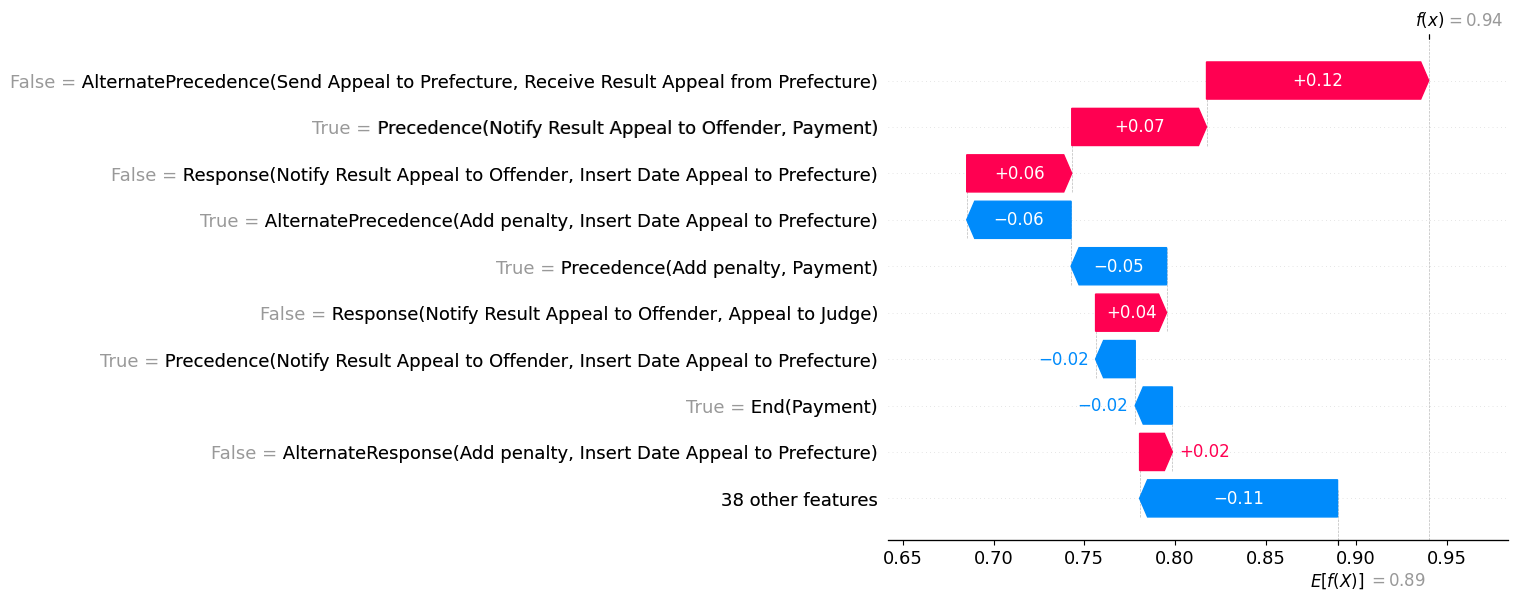

In [18]:
# the trace used in out publication
paper_trace = [
    'Create Fine',
    'Send Fine',
    'Insert Fine Notification', 
    'Add penalty',
    'Receive Result Appeal from Prefecture',
    'Notify Result Appeal to Offender',
    'Payment'
]

instance_to_explain = [i for i,x in enumerate(surrogate_ds) if x.sequence == paper_trace].pop()

instance = surrogate_ds[instance_to_explain]

print(instance)

shap.plots.waterfall(shap_values[instance_to_explain, :,instance.rnn_predicted_label], show=False)
pl.savefig("../img/rtfmp_shap_good.pdf",bbox_inches='tight')
pl.show()



The resulting explanation correctly identifies the root cause of the non-conformance: the absence of the `Insert Date Appeal to Prefecture` and `Send Appeal to Prefecture` activities. This is captured by the high importance of two key Declare constraints:
- `AlternatePrecedence(Send Appeal to Prefecture, Receive Result Appeal from Prefecture)`
- `Precedence(Notify Result to Offender, Payment)`

Furthermore, the SHAP plot reveals a clear pattern: satisfied constraints tend to push the prediction towards "conforming," while violated constraints push it towards "non-conforming."

### Explaining an Incorrect Prediction

Next, we analyze a case where the RNN model makes an incorrect prediction. This helps us understand the model's failure modes and identify which declarative features might be misleading it.

The following trace:
![conformant trace](./eventlogs/rtfmp/rtfmp_conformant_trace.png)
was incorrectly identified as non-conformant.

Create Fine
 ->Send Fine
 ->Insert Fine Notification
 ->Add penalty
 ->Send for Credit Collection 

 predicted as 0,  --  ground truth: 1


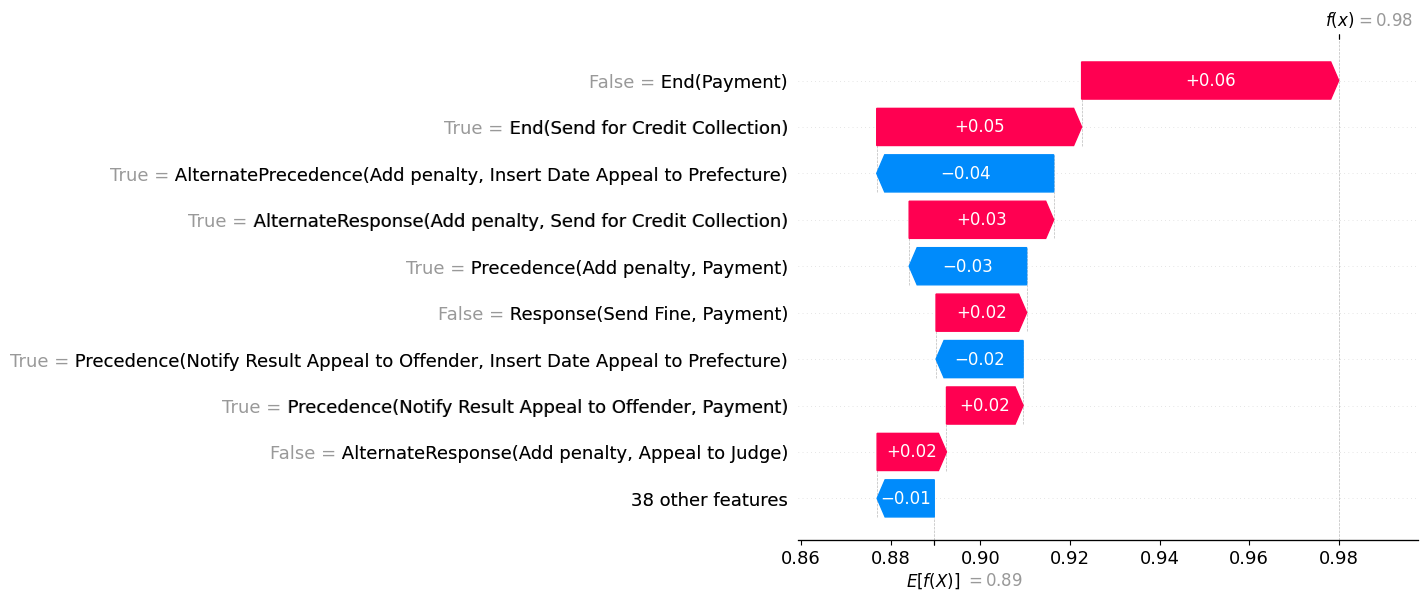

In [19]:
# get all instances that have been wrongly predicted

incorrectly_predicted_instances = [i for i, x in enumerate(surrogate_ds) if not x.correctly_predicted()]

incorrect_predicted_instance_index = incorrectly_predicted_instances[0]

incorrect_predicted_instance = surrogate_ds[incorrect_predicted_instance_index]

print(incorrect_predicted_instance)

shap.plots.waterfall(shap_values[incorrect_predicted_instance_index, :,incorrect_predicted_instance.rnn_predicted_label],show = False)
pl.savefig("../img/rtfmp_shap_bad.pdf", bbox_inches='tight')
pl.show()


The explanation reveals that the surrogate model—and by extension, the RNN—incorrectly learned the process flow. Specifically, it failed to recognize the valid path where a sequence concludes with the `Send for Credit Collection` event.

The SHAP analysis highlights that the two most influential features driving this misclassification are:

- `End(Payment)` = False: The absence of Payment as the final event strongly pushed the prediction toward "non-conforming."
- `End(Send for Credit Collection)` = True: The presence of Send for Credit Collection as the final event also contributed to the "non-conforming" prediction, indicating the model has misinterpreted this valid ending.